# Pong-Playing TensorFlow Neural Network

## Import modules needed to train neural network in Pong environment

In [1]:
import gym
import numpy as np
import tensorflow as tf
from IPython import display
import matplotlib.pyplot as plt
import time

config = tf.ConfigProto()
#config.gpu_options.allow_growth = True

%matplotlib inline

## Investigate the environment and set up data preprocessing functions

[2017-11-08 03:22:31,590] Making new env: Pong-v0


Discrete(6)
['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


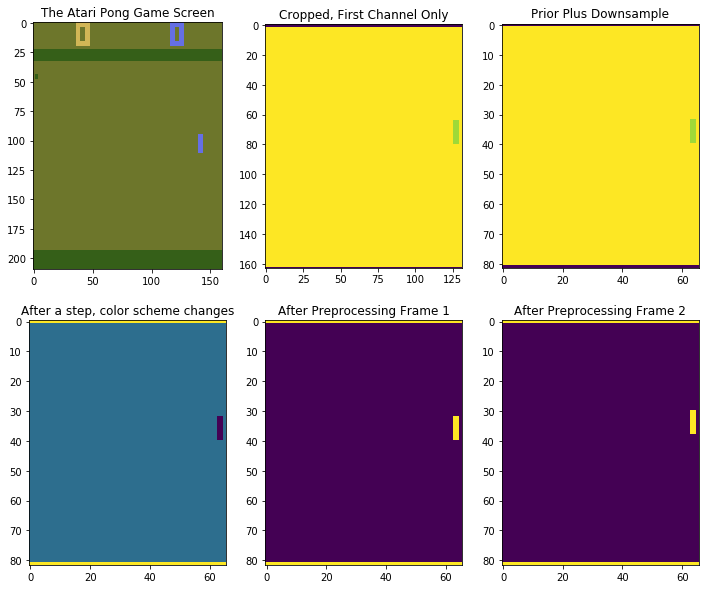

In [2]:
env = gym.make("Pong-v0")
env.render(mode='rgb_array').shape
env.reset()
print(env.action_space)
print(env.unwrapped.get_action_meanings())

top = 32
bottom = 195
left = 14
right = 146
downsampled_height = int(np.rint((bottom-top)/2))
downsampled_width = int(np.rint((right-left)/2))
input_dim = downsampled_height*downsampled_width

def preprocess(img, reshape=False):
    #crop, grab only one channel, and downsample by factor of 2
    img = img[top:bottom,left:right,0][::2,::2] 
    #get rid of background color, 109 in first frame, 144 otherwise
    img[np.isin(img,[144,109])] = 0 
    img[img!=0] = 1
    if not reshape:
        return img.astype(np.int).ravel()
    else:
        return img.astype(np.int)

def reshape(img):
    return img.reshape(downsampled_height,downsampled_width).astype(np.int)

#what color pixels are in this image?
#print(list(zip(*np.unique(env.render(mode='rgb_array')[top:bottom,left:right,0],return_counts=1))))
#print(list(zip(*np.unique(env.render(mode='rgb_array')[top:bottom,left:right,0][::2,::2],return_counts=1))))

plt.subplots(2,3, figsize=(12,10))

plt.subplot(2,3,1)
plt.title("The Atari Pong Game Screen")
plt.imshow(env.reset())

plt.subplot(2,3,2)
plt.title("Cropped, First Channel Only")
plt.imshow(env.render(mode='rgb_array')[top:bottom,left:right,0])

plt.subplot(2,3,3)
plt.title("Prior Plus Downsample")
plt.imshow(env.render(mode='rgb_array')[top:bottom,left:right,0][::2,::2])

plt.subplot(2,3,4)
plt.title("After a step, color scheme changes")
plt.imshow(env.step(2)[0][top:bottom,left:right,0][::2,::2])

plt.subplot(2,3,5)
plt.title("After Preprocessing Frame 1")
plt.imshow(reshape(preprocess(env.reset())))

plt.subplot(2,3,6)
plt.title("After Preprocessing Frame 2")
plt.imshow(reshape(preprocess(env.step(2)[0])))
plt.show()

#print(list(zip(*np.unique(env.render(mode='rgb_array')[top:bottom,left:right,0][::2,::2],return_counts=1))))
#print(list(zip(*np.unique(reshape(preprocess(env.reset())),return_counts=1))))
#print(list(zip(*np.unique(reshape(preprocess(env.render(mode='rgb_array'))),return_counts=1))))

## Define and initialize the neural network

In [3]:
sess = tf.InteractiveSession(config=config)

x = tf.placeholder(tf.float32, shape=[None, input_dim])
advantage = tf.placeholder(tf.float32, shape=[None])
action = tf.placeholder(tf.int8, shape=[None])
move_down_action = tf.Variable(3, dtype=tf.int8)

h1_dim = 200
l1 = tf.layers.dense(x, h1_dim, activation=tf.nn.relu)
move_down_prob = tf.layers.dense(l1, 1, activation=tf.nn.sigmoid)
sampled_action_log_prob = tf.where(tf.equal(action, move_down_action),
                                     tf.log(move_down_prob),
                                     tf.log(1-move_down_prob))
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4)
train = optimizer.minimize(tf.reduce_sum(-advantage*sampled_action_log_prob))

saver = tf.train.Saver()
tf.global_variables_initializer().run()

## Set up an agent class that plays pong using actions chosen by the neural network in the active TensorFlow session

In [ ]:
class pong_agent:
        
    def clean_slate(self):    
        self.wins = 0
        self.games = 0    
        self.p_list = []
        self.actions = []
        self.frames = []
        self.rewards = []

    def make_batch(self, n_sets):
        self.clean_slate()
        for _ in range(n_sets):
            self.play_set()
        self.normalize_rewards()
        return self.rewards, self.frames, self.actions, self.p_list, self.wins, self.games

    def play_set(self):
        env.reset()
        done = 0
        while not done:
            self.frames.append(preprocess(env.render(mode='rgb_array')))
            done = self.play_point(self.frames[-1])

    def play_point(self, last_frame):
        frames_played = 0
        discount = 0.99
        while True:
            prob, action, reward, new_frame, done = self.play_frame(self.frames[-1] - last_frame)
            self.p_list.append(prob)
            self.actions.append(action)
            frames_played+= 1
            if reward:
                self.rewards+= [reward * discount**k for k in reversed(range(0,frames_played))]
                self.wins+= max(reward,0)
                self.games+= 1
                break
            last_frame = self.frames[-1]
            self.frames.append(new_frame)
        return done

    def play_frame(self, frame_change):
        p_down = sess.run(move_down_prob, feed_dict={x:np.array([frame_change])}).reshape(1)[0]
        #sample an action using p_down, 3=down, 2=up
        action = np.random.binomial(1, p_down) + 2 
        observation, reward, done = env.step(action)[:3]
        return p_down, action, reward, preprocess(observation), done

    def normalize_rewards(self):
        mean = np.mean(self.rewards)
        std_dev = np.std(self.rewards)
        self.rewards = (np.array(self.rewards)-mean)/std_dev

## Train the agent for 2000 updates to reach >50% win rate

This part takes a while. My setup processes ~100 batches/hour. To monitor progress (the agent's win rate), I output at a .PNG plot every 10 batches. There's a visible shift in the win rate from ~2% to ~4% by batch 300.

In [ ]:
start = time.time()
ratios = []
matches_per_batch = 10
epochs = 2000
agent = pong_agent()

for i in range(epochs):
    #play Pong with the network, save frames and associated rewards
    reward, frames, actions, p_list, w, g = agent.make_batch(matches_per_batch)
    frame_changes = list(np.array(frames[1:])-np.array(frames[:-1]))
    frame_changes.insert(0,np.zeros_like(frame_changes[0]))
    train.run(feed_dict={x: frame_changes, advantage: reward, action: actions})
    ratios.append(w/g*100)
    if i%10==0:
        print("{}: batch {} finished after {} hours".format(time.strftime('%X %x '), 
                                                    i, round((time.time()-start)/3600,2)))
        plt.title("Agent Quality over Time")
        plt.plot(range(1,i+2), ratios)
        plt.xlabel("Number of Updates")
        plt.ylabel("Percent of Games Won")
        plt.savefig("./pong_agent_quality")
        if i%100==0:
            #save out the neural network's weights here
            saver.save(sess, "./pong_agent.ckpt")

## View the last game played

In [ ]:
'''
watch the agent's Pong play in the most recent game. the right side of the plot is the 
difference frame that the agent/neural-network uses to predict a good action to take
'''
def concat(one, two):
    border = np.ones((downsampled_height,3))*3
    return np.concatenate([one,border,two], axis=1)

duration = 500 # number of frames to watch
img = plt.imshow(concat(reshape(frames[0]) , reshape(frame_changes[1])))
for i in range(min(len(frames), duration)):
    img.set_data(concat(reshape(frames[i]) , reshape(frame_changes[i])))
    plt.title("Move Down with Probability %.2f" % p_list[i])
    display.display(plt.gcf())
    display.clear_output(wait=True)